In [22]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.utilities.model_summary import ModelSummary
from pytorch_lightning.loggers import WandbLogger
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import wandb
import torchmetrics
import sys
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray import tune

# Lightning module (= model)

In [2]:
class ImageEncoder(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=2e-4):
        super().__init__()
        # save input_shape, num_classes, learning_rate
        self.save_hyperparameters()
        # Feature extractor
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Get the size of output tensor from feature extractor
        n_sizes = self._get_conv_output((3,96,96))
        
        # dense layer to calculate logits
        # Output is one float value
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_sizes, 240),
            nn.ReLU(),
            nn.Linear(240, 120),
            nn.ReLU(),
            nn.Linear(120, 80),
            nn.ReLU(),
            nn.Linear(80, 1)
        )
        
        # Metrics: accuracy
        self.accuracy = torchmetrics.Accuracy(task='binary')
    
    # forward propagation. activation function: ReLU and Sigmoid.
    def forward(self, x):
        x = self.encoder(x)
        x = self.dense(x)
        return torch.sigmoid(x)
    
    # Training step
    # calculate loss, backforward propagation is already implemented.
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        pred = y_hat.round()
        return {"loss":loss, 'pred':pred, 'y':y}
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        pred = torch.cat([x['pred'] for x in outputs]).to(device=torch.device(self.device))
        
        y = torch.cat([x['y'] for x in outputs]).to(torch.int32)
        y = torch.squeeze(y)
        
        pred = torch.flatten(pred)
        y = torch.flatten(y)
        
        avg_acc = self.accuracy(pred, y)
        self.log("train_loss", avg_loss, prog_bar=True, on_epoch=True)
        self.log("train_acc", avg_acc, prog_bar=True, on_epoch=True)
    
    # Same steps for validation 
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        pred = y_hat.round()
        val_loss = F.binary_cross_entropy(y_hat, y)
        return {'val_loss':val_loss,'pred':pred, 'y':y}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        pred = torch.cat([x['pred'] for x in outputs]).to(device=torch.device(self.device))
        y = torch.cat([x['y'] for x in outputs]).to(torch.int32)
        y = torch.squeeze(y)
        
        pred = torch.flatten(pred)
        y = torch.flatten(y)

        avg_acc = self.accuracy(pred, y).item()
        self.log("val_loss", avg_loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", avg_acc, prog_bar=True, on_epoch=True)
    
    # set optimizer and learning rate scheduler
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.00001)
        return [optimizer], [scheduler]
    
    def optimizer_step(self,
                     epoch=None, 
                    batch_idx=None, 
                    optimizer=None, 
                    optimizer_idx=None, 
                    optimizer_closure=None, 
                    on_tpu=None, 
                    using_native_amp=None, 
                    using_lbfgs=None
                     ):
        optimizer.step(closure=optimizer_closure)
        optimizer.zero_grad()
        self.lr_schedulers().step()
    
    # function to calculate output size of conv2d layer.
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.encoder(input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
    


# Dataset

In [3]:
class CancerDataset(Dataset):
    def __init__(self, label_dir, img_dir, transform=None):
        self.img_labels = pd.read_csv(label_dir)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        # label file has two columns: id, label
        # to read each images from dir
        img_path = self.img_dir + '/'+ self.img_labels.iloc[idx,0] + '.tif'
        # read image as numpy array and normalize it
        image = Image.open(img_path)
#         image_array = self.transform(image) / 255.0
        image_array = self.transform(image)
        
        # read label
        label = self.img_labels.iloc[idx, 1].astype('float32')
        label = torch.Tensor([label])
        # return image array and label
        return image_array, label

# Train and validation set separator

In [4]:
def train_val_dataset(dataset, train_split=0.75, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), train_size=train_split, test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

# Data Module
Do some preprocessing and make data loader for train and validation

In [5]:
class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, label_dir, img_dir):
        super().__init__()
        self.batch_size = batch_size
        self.dims = (3, 96, 96)
        self.num_classes = 1
        self.label_dir = label_dir
        self.img_dir = img_dir
        
        # transform to preprocess images
        # random horizontal flip: flip image to create new data
        # to tensor: change value range to 0 ~ 1
        # normalize: change value range to -1 ~ 1
        self.transform = transforms.Compose([
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
       ])
    
    def setup(self, stage=None):
        data = CancerDataset(label_dir=self.label_dir,
                          img_dir=self.img_dir,
                          transform=self.transform
                    )
        
        # split data as 70% of train data and 30% of validation data
        train_n = int(len(data) * wandb.config['data_size'] * 0.7)
        val_n = int(len(data) * wandb.config['data_size'] * 0.3)
        dataset = train_val_dataset(data, train_split=train_n, val_split=val_n)
        self.train_dataset = dataset['train']
        self.val_dataset = dataset['val']
    
    # return data loader with selected batch size setting.
    # Train data loader shuffles data.
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)       

In [6]:
wandb.login()

wandb: Currently logged in as: respwill. Use `wandb login --relogin` to force relogin


True

In [7]:
# wandb.init(
# #               mode='disabled',
#   # Set the project where this run will be logged
#   project="histopathologic-cancer-classifier", 
#   # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
#   name=f"Test{n_test}", 
#   # Track hyperparameters and run metadata
#   config={
#   "learning_rate": lr,
#   "data_size": 1,
#   "batch_size":b,
#   })

# Callbacks to save check point

In [12]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='./check_point/', 
    filename='{epoch}-{train_loss:.4f}-{val_loss:.4f}', 
    monitor="val_loss", 
    mode="min", 
    save_top_k=5
)

# Hyperparamater search
Check what conbminations of batch size and learning rate produces the best results.

In [13]:
import numpy as np

In [14]:
parameter_dict = {
    'learing_rate':np.linspace(start=0.0005, stop=0.00001, num=5),
    'batch_size':[32, 64, 128]
}

# Hyper parameter search

Function to run fit with provided hyperparameters.  
Acrually I wanted to run codes using Ray packages.. but failed..

In [15]:
def train_histopathlogic(num_epohcs=10, batch_size=32, learning_rate=0.0005):
    # Data module to control dataset and dataloader
    dm = DataModule(batch_size=batch_size, 
                label_dir="./train_labels_balance.csv",
                img_dir="../histopathologic-cancer-detection_data/train/")
    
    # Model to run
    im_encoder = ImageEncoder(input_shape=dm.dims, 
                          num_classes=dm.num_classes, 
                          learning_rate=learning_rate)
    
    # Trainer to run model
    trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                    max_epochs=num_epohcs,
                     logger=wandb_logger,
                    callbacks=[checkpoint_callback])
    
    # Fit model using dataloader that datamodule provides.
    trainer.fit(im_encoder, dm)

In [18]:
n_test = 1
for b in parameter_dict['batch_size']:
    for lr in parameter_dict['learing_rate']:
        
        wandb.init(
#               mode='disabled',
              # Set the project where this run will be logged
              project="histopathologic-cancer-classifier", 
              # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
              name=f"Test{n_test}", 
              # Track hyperparameters and run metadata
              config={
              "learning_rate": lr,
              "data_size": 1,
              "batch_size":b,
              })
        wandb_logger = WandbLogger()
        train_histopathlogic(batch_size=b, learning_rate=lr)
        wandb.finish()
        n_test += 1

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▄▅▅▇▅▇▆█▇
val_loss,█▆▄▅▂▄▂▂▁▂
epoch,9
train_acc,0.89496
train_loss,0.25595
trainer/global_step,38989
val_acc,0.88272


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▃▅▆▇▆█▆█▇
val_loss,█▇▄▃▂▂▁▂▁▂
epoch,9
train_acc,0.88768
train_loss,0.27134
trainer/global_step,38989
val_acc,0.87801


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▄▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▂▄▅▆▆▇▆██
val_loss,█▆▅▄▃▄▂▃▁▁
epoch,9
train_acc,0.8856
train_loss,0.27494
trainer/global_step,38989
val_acc,0.87947


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▃▅▄▆▆▇▇█▆
val_loss,█▆▄▆▃▃▂▂▁▄
epoch,9
train_acc,0.8668
train_loss,0.31366
trainer/global_step,38989
val_acc,0.8429


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▂▃▅▆▅▆▇▇█
val_loss,█▇▅▄▃▃▃▂▂▁
epoch,9
train_acc,0.81821
train_loss,0.40979
trainer/global_step,38989
val_acc,0.81969


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▄▅▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▃▁▄▆▇▇▇▇█
val_loss,█▆█▅▃▂▂▂▂▁
epoch,9
train_acc,0.8874
train_loss,0.27117
trainer/global_step,19499
val_acc,0.88711


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▄▄▅▆▇▆▆██
val_loss,█▅▅▄▃▂▂▃▂▁
epoch,9
train_acc,0.88625
train_loss,0.27542
trainer/global_step,19499
val_acc,0.88502


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▄▄▅▆▆▇▅▇█
val_loss,█▆▅▄▃▃▃▄▂▁
epoch,9
train_acc,0.86909
train_loss,0.31079
trainer/global_step,19499
val_acc,0.86933


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▄▆▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▄▅▅▆▇▆▇██
val_loss,█▅▅▄▃▃▃▂▂▁
epoch,9
train_acc,0.8626
train_loss,0.32354
trainer/global_step,19499
val_acc,0.8646


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▅▅▆▆▇▇███
train_loss,█▅▄▄▃▂▂▁▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▂▃▅▆▆▇▇██
val_loss,█▇▆▄▃▃▂▂▂▁
epoch,9
train_acc,0.81459
train_loss,0.41501
trainer/global_step,19499
val_acc,0.81339


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▄▅▆▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,9
train_acc,0.88462
train_loss,0.27494
trainer/global_step,9749
val_acc,0.88023


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▄▅▆▇▇▇▆██
val_loss,█▆▄▃▃▂▂▃▁▁
epoch,9
train_acc,0.87326
train_loss,0.29834
trainer/global_step,9749
val_acc,0.86996


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▂▄▅▅▆▆▇▇█
val_loss,█▇▅▄▄▃▃▂▂▁
epoch,9
train_acc,0.85033
train_loss,0.34361
trainer/global_step,9749
val_acc,0.85713


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▃▄▅▆▇▇▇██
val_loss,█▆▅▃▃▂▂▂▁▁
epoch,9
train_acc,0.83995
train_loss,0.36409
trainer/global_step,9749
val_acc,0.84374


C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\core\datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: True, used: True
TPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_acc,▁▆▆▇▇▇▇███
train_loss,█▄▃▃▃▂▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
val_acc,▁▂▃▃▃▅▅▆▄█
val_loss,█▇▆▆▅▄▄▂▃▁
epoch,9
train_acc,0.80344
train_loss,0.43434
trainer/global_step,9749
val_acc,0.80739


# Hyper parameter search results
After searching for several combinations of batch_size and leaerning_rate,  
I concluded that batch_size 32 and learning_rate 0.0005 is the best hyperparameter for this model.  

In [24]:
from IPython.display import Image

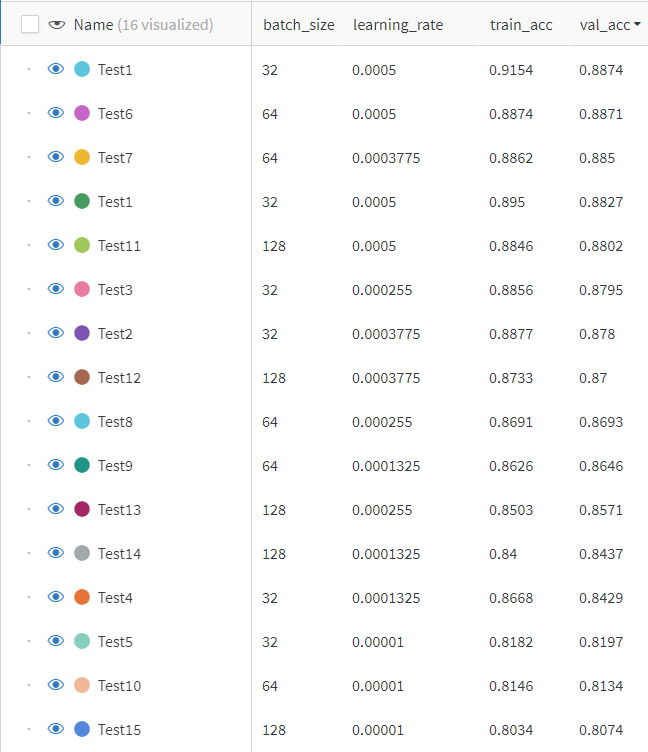

In [25]:
Image(filename='./hp_search.png')

# Run the best hyperparameter model

In [ ]:
wandb.init(
#               mode='disabled',
      # Set the project where this run will be logged
      project="histopathologic-cancer-classifier", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"Test1", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0005,
      "data_size": 1,
      "batch_size":32,
      })
wandb_logger = WandbLogger()

In [201]:
trainer = pl.Trainer(accelerator='cpu',
                     devices=1,
                    max_epochs=200,
                     logger=wandb_logger,
                    callbacks=[checkpoint_callback])

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/haeinpark/miniconda3/envs/boulder/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [202]:
trainer.fit(im_encoder, dm)

/Users/haeinpark/miniconda3/envs/boulder/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/haeinpark/Documents/GitHub/histopathologic-cancer-detection/check_point exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name     | Type           | Params
--------------------------------------------
0 | encoder  | Sequential     | 15.7 K
1 | dense    | Sequential     | 530 K 
2 | accuracy | BinaryAccuracy | 0     
--------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.185     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/haeinpark/miniconda3/envs/boulder/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/haeinpark/miniconda3/envs/boulder/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/Users/haeinpark/miniconda3/envs/boulder/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:362: LightningDeprecationWarning: The NVIDIA/apex AMP implementation has been deprecated upstream. Consequently, its integration inside PyTorch Lightning has been deprecated in v1.9.0 and will be removed in v2.0.0. The `ImageEncoder.optimizer_step()` hook is overridden, including the `using_native_amp` argument. Removing this argument will avoid this message, you can expect it to return True.
  rank_zero_deprecation(
/Users/haeinpark/miniconda3/envs/boulder/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Wandb log

In [91]:
from IPython.display import Image

The best accuracy is at 8th epochs (The graph is 0 index)

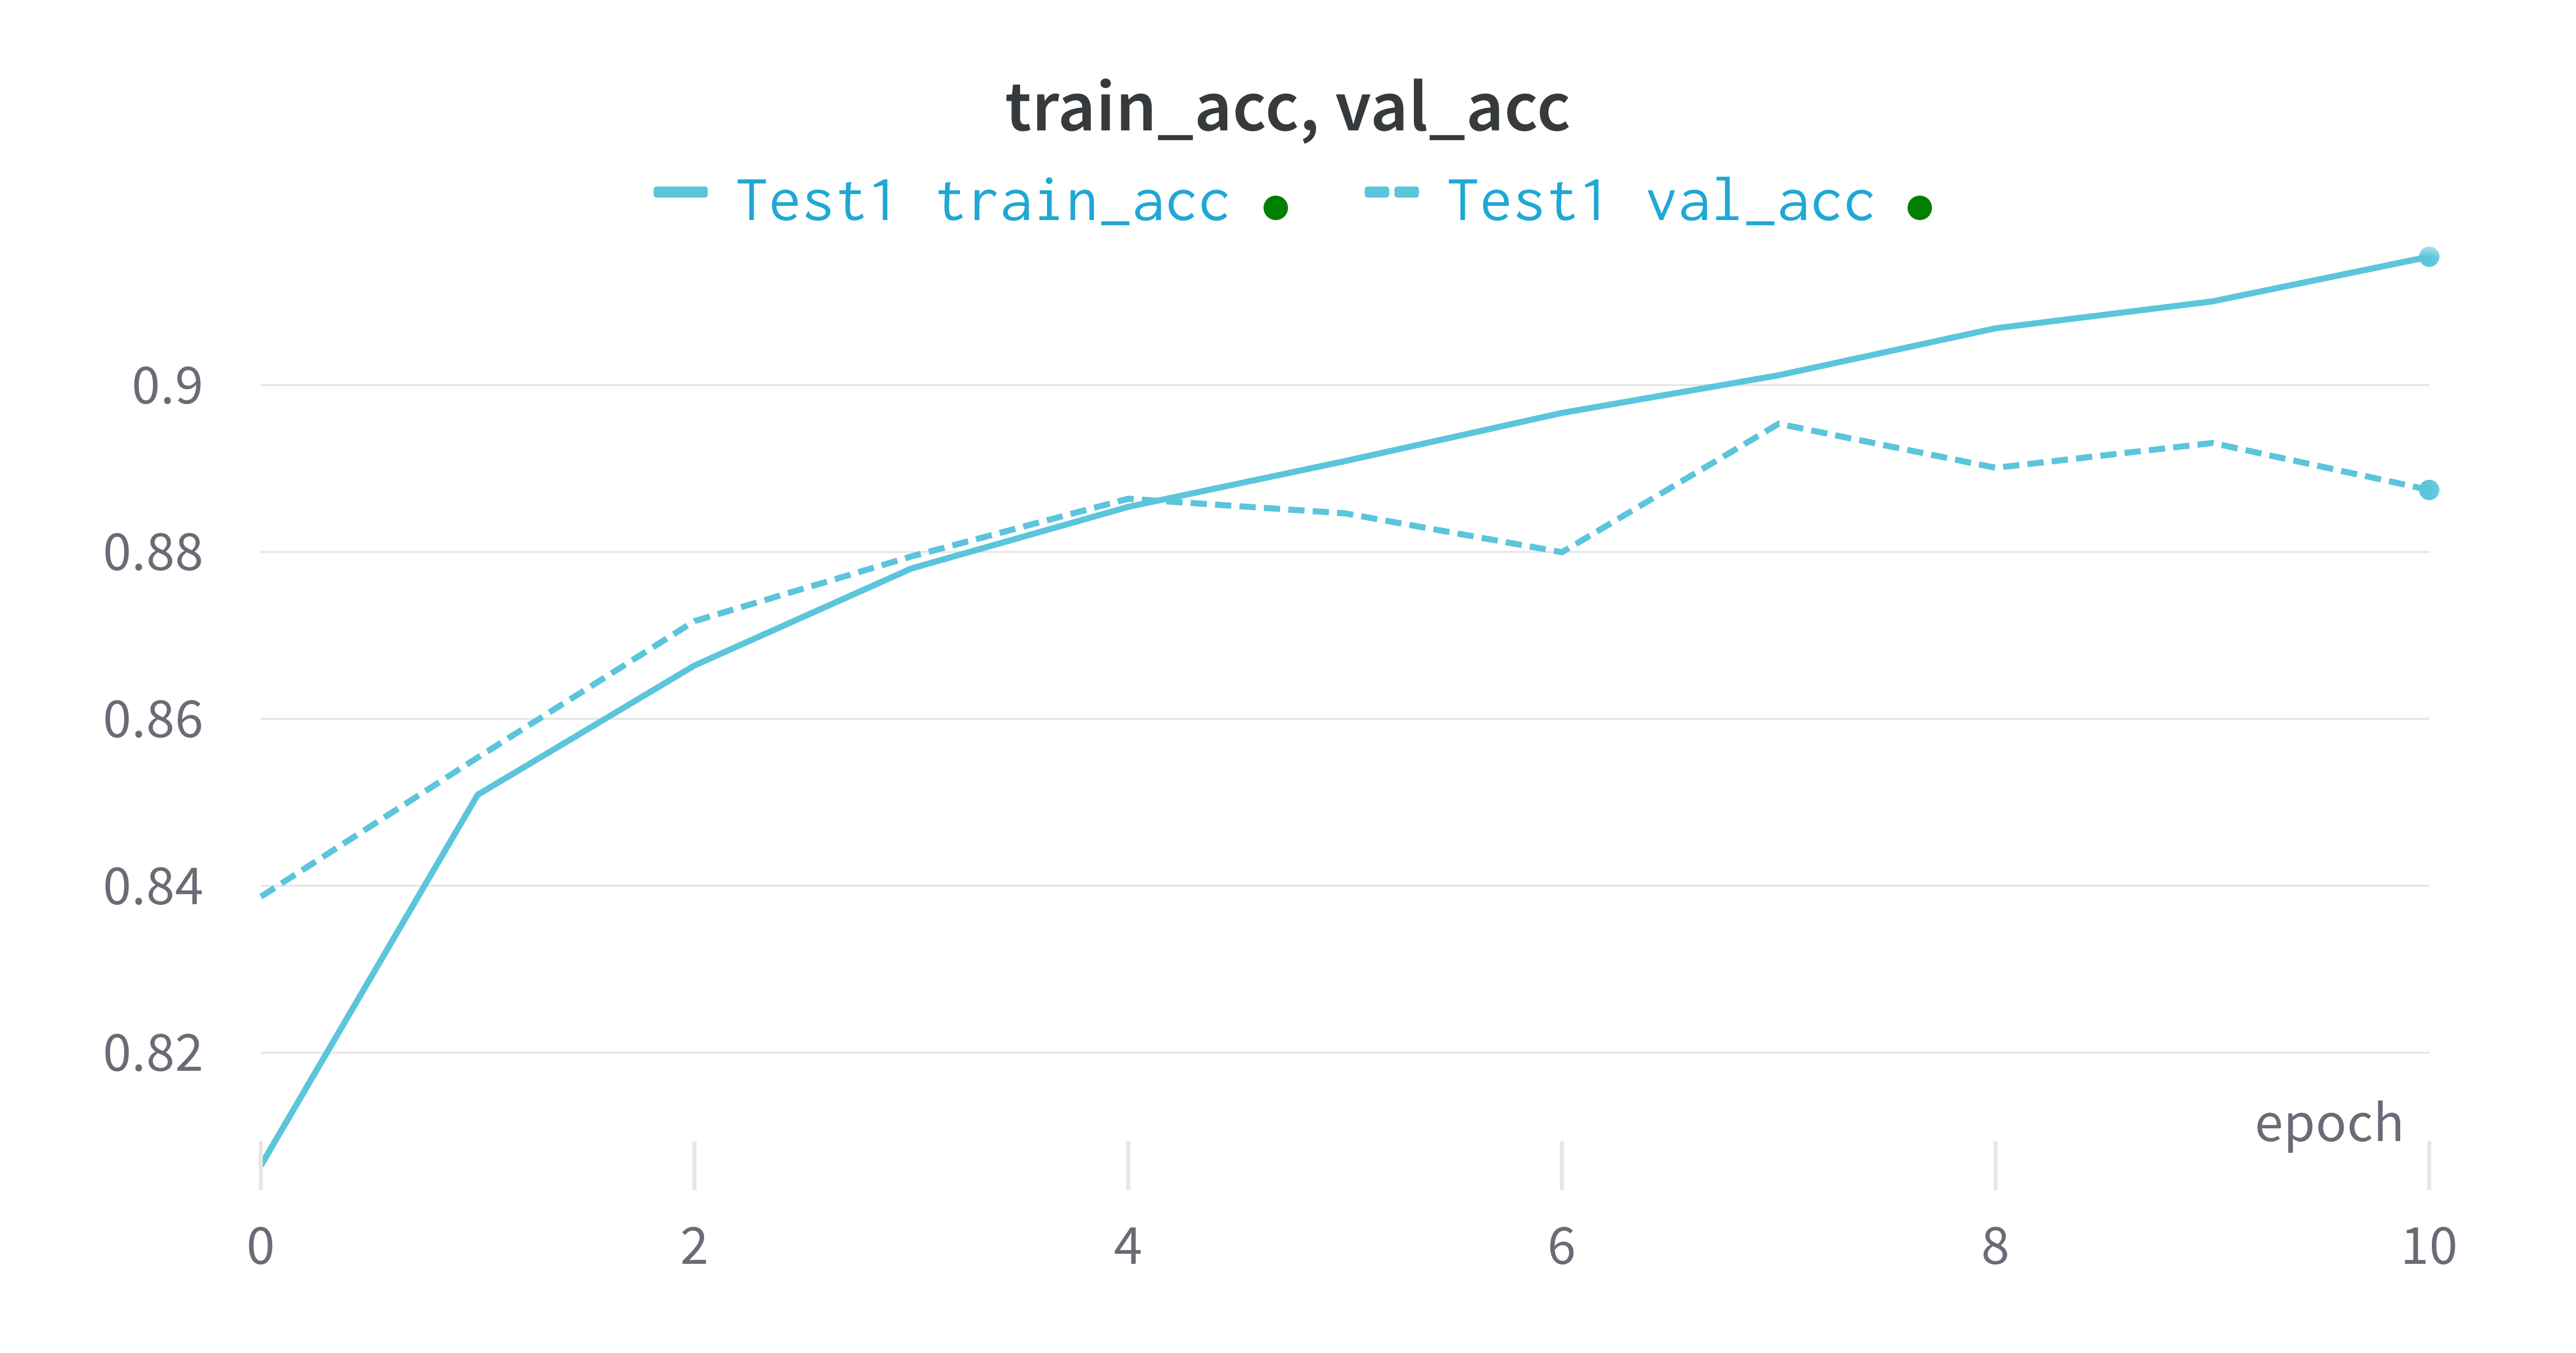

In [92]:
Image(filename='//Users/haeinpark/Downloads/W&B Chart 2023. 2. 18. 오전 11_07_48.png')

Validation loss began to increase from 8th epochs. (Over-fitting)

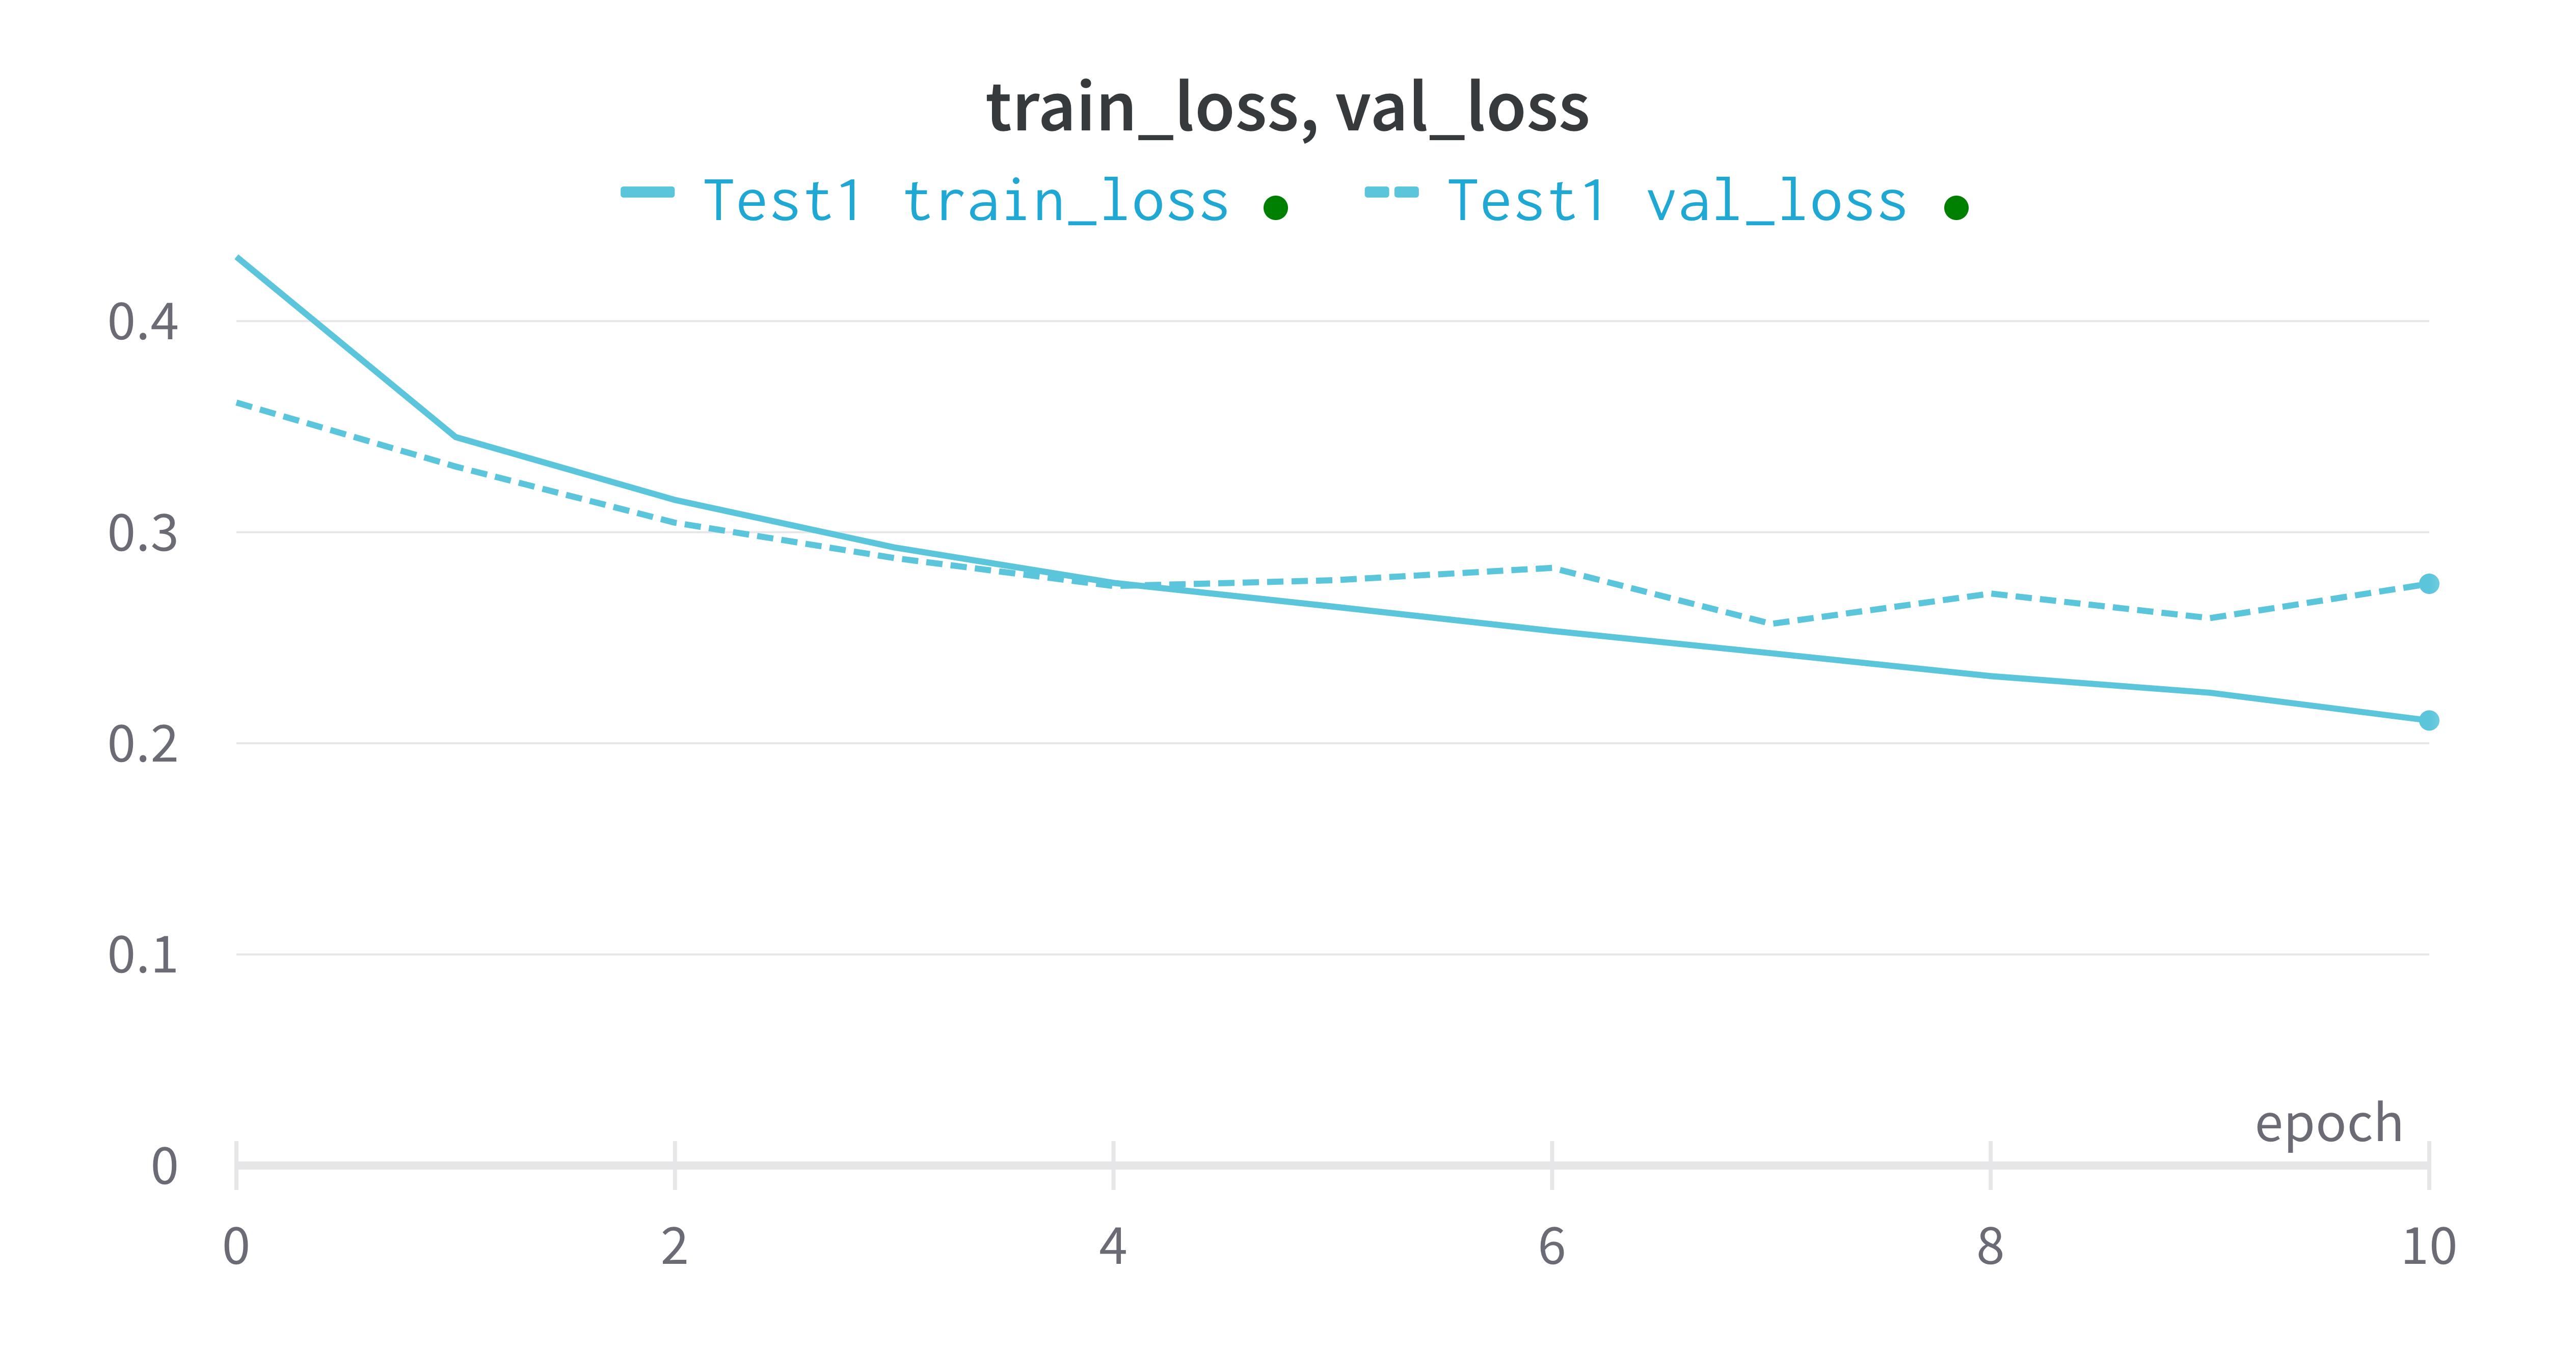

In [93]:
Image(filename='//Users/haeinpark/Downloads/W&B Chart 2023. 2. 18. 오전 11_08_27.png')

# Load the best model
8th epoch model achieved the best validation accuracy

In [32]:
im_encoder = ImageEncoder(input_shape=dm.dims, 
                          num_classes=dm.num_classes, 
                          learning_rate=wandb.config['learning_rate']).load_from_checkpoint("./check_point/epoch=7-train_loss=0.2427-val_loss=0.2566.ckpt")

Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file check_point/epoch=7-train_loss=0.2427-val_loss=0.2566.ckpt`


cpu
cpu


## Predict Validation set to amend threshold.

In [33]:
im_encoder.eval()
eval_dataloader = dm.val_dataloader()

logits = []
target = []
with torch.no_grad():
    for batch in eval_dataloader:
        x,y = batch
        y_hat = im_encoder(x)
        logits.extend(y_hat)
        target.extend(y)

In [34]:
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, f1_score

In [35]:
import numpy as np

In [36]:
target_np = torch.cat(target).detach().numpy()
logits_np = torch.cat(logits).detach().numpy()

In [37]:
pred_05 = np.where(logits_np>=0.5, 1, 0)

In [38]:
acc_05 = accuracy_score(target_np, pred_05)

In [39]:
f1_05 = f1_score(target_np, pred_05)

# Accuracy and F1 with 0.5 threshold
8th epoch model achieved 90% of accuracy

In [40]:
acc_05, f1_05

(0.9069945763979802, 0.906036844591403)

In [41]:
fpr, tpr, _ = roc_curve(target_np, logits_np)

In [43]:
import matplotlib.pyplot as plt

### ROC curve

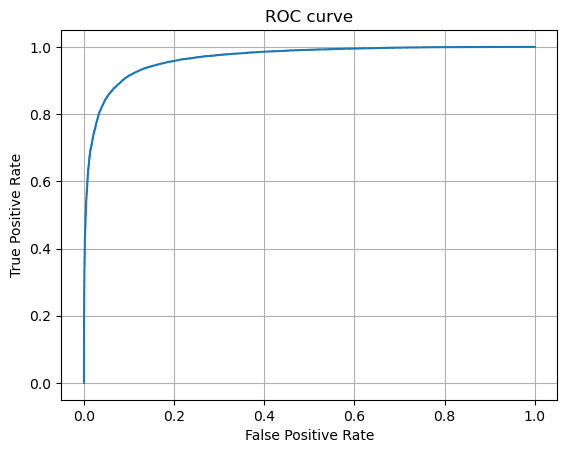

In [44]:
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.title('ROC curve');

### Precision, Recall Curve

In [45]:
precision, recall, threshold = precision_recall_curve(target_np, logits_np)

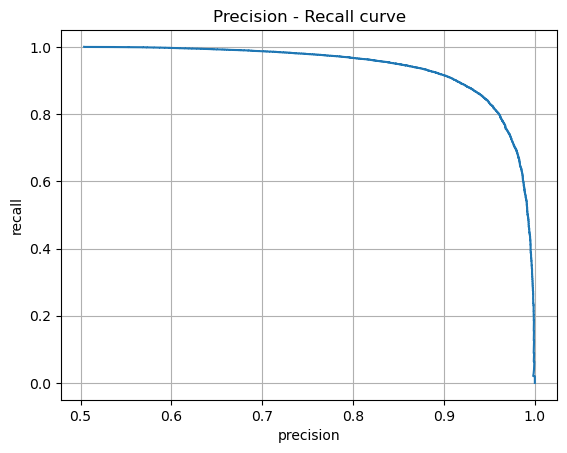

In [46]:
plt.plot(precision, recall)
plt.ylabel('recall')
plt.xlabel('precision')
plt.grid()
plt.title('Precision - Recall curve');

In [69]:
for pre, rec, thr in zip(precision, recall, threshold):
    if (pre >= 0.90) & (rec >= 0.91):
        print(pre, rec, thr)

0.9000220620679512 0.9158497343410911 0.41805834
0.9000551571980143 0.9158497343410911 0.41814318
0.9000882547620799 0.9158497343410911 0.41833794
0.9000845805905932 0.9158123175933548 0.4183499
0.9001176816710798 0.9158123175933548 0.41857004
0.9001140083115737 0.9157749008456185 0.41862848
0.9001103346818683 0.9157374840978822 0.41874516
0.9001066607819339 0.915700067350146 0.41876727
0.9001029866117405 0.9156626506024096 0.41877732
0.9000993121712583 0.9156252338546733 0.41914153
0.9000956374604576 0.915587817106937 0.41915467
0.9000919624793084 0.9155504003592008 0.4192104
0.9001250735726898 0.9155504003592008 0.41922233
0.900158187102233 0.9155504003592008 0.4192701
0.9001913030682069 0.9155504003592008 0.41928953
0.9002244214708804 0.9155504003592008 0.41937798
0.9002575423105225 0.9155504003592008 0.41943157
0.900290665587402 0.9155504003592008 0.4197657
0.9003237913017882 0.9155504003592008 0.4198352
0.9003201236339552 0.9155129836114645 0.42011577
0.9003164556962026 0.91547556

Best threshold = 0.44770354

In [70]:
threshold_new = 0.44770354

In [71]:
pred_new = np.where(logits_np>=threshold_new, 1, 0)

In [72]:
acc_new = accuracy_score(target_np, pred_new)

In [73]:
f1_new = f1_score(target_np, pred_new)

In [74]:
acc_new, f1_new

(0.9075369365999626, 0.9077370955100212)

# Predict Test set

In [75]:
test_data = CancerDataset(label_dir="//Users/haeinpark/Downloads/histopathologic-cancer-detection/sample_submission.csv",
                          img_dir="//Users/haeinpark/Downloads/histopathologic-cancer-detection/test/",
                          transform=dm.transform
                    )

In [76]:
test_dataloader = DataLoader(test_data,
                            batch_size=32,
                            )

In [77]:
test_logits = []
with torch.no_grad():
    for batch in test_dataloader:
        x,y = batch
        y_hat = im_encoder(x)
        test_logits.extend(y_hat)

In [78]:
test_logits_np = torch.cat(test_logits).detach().numpy()

In [79]:
pred_test = np.where(test_logits_np>=threshold_new, 1, 0)

In [81]:
submit_file = pd.read_csv("//Users/haeinpark/Downloads/histopathologic-cancer-detection/sample_submission.csv")

In [82]:
submit_file.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [83]:
submit_file['label'] = pred_test

In [86]:
submit_file.to_csv("//Users/haeinpark/Downloads/histopathologic-cancer-detection/sample_submission_edit.csv", 
                   index=False)

# Conclusion

What I tried:
* Increasing conv2d layers and dense layers
* Increasing number of nodes
* Add transforms

Firstly, I just normalize image data as dividing each channel of images by 255.  
But It did not help the model to capture features.  
On the same preprocessing condition, increasing layers and nodes was not helpful either.

My model began to capture features after inserting transforms to flip images horizontally.
And normalized images so that value range became -1 ~ 1.

It may be helpful to increase the number of layers and nodes after properly normalizing images.  
But I didn't try since my model already captured some features and learned pattern.  

I concluded that data preprocessing is much more important to make better performance.  